# Baseline Model

## Imports and Constants

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import joblib

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
RANDOM_SEED = 8
DATA_PATH = 'data/'
MODEL_PATH = 'models/'

## Read in Data

In [3]:
df = pd.read_csv(DATA_PATH+'clean_water_well_data.csv')
df.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,subvillage,region,lga,...,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
0,2011-03-14,roman,1390.000000,roman,34.938093,-9.856322,0,Mnyusi B,Iringa,Ludewa,...,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional
1,2013-03-06,grumeti,1399.000000,grumeti,34.698766,-2.147466,0,Nyamara,Mara,Serengeti,...,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,2013-02-25,lottery club,686.000000,world vision,37.460664,-3.821329,0,Majengo,Manyara,Simanjiro,...,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
3,2013-01-28,unicef,263.000000,unicef,38.486161,-11.155298,0,Mahakamani,Mtwara,Nanyumbu,...,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,2011-07-13,action in a,1018.821805,artisan,31.130847,-1.825359,0,Kyanyamisa,Kagera,Karagwe,...,True,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


## Split data into features and labels

In [4]:
y = df.status_group
X = df.drop('status_group', axis=1)

## Drop Unwanted Features

In [5]:
# high cardinality features
high_card = ['funder', 'installer', 'lga', 'subvillage', 'ward']

# not useful features
not_useful = ['date_recorded', 'longitude', 'latitude']

unwanted = high_card + not_useful

X = X.drop(unwanted, axis=1)

## Train / Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

## Scale Continuous Features

In [7]:
cols_to_scale = ['gps_height', 'num_private', 'population', 'construction_year']

In [8]:
ct = ColumnTransformer([('column_scaler', 
                        StandardScaler(), 
                        cols_to_scale)],
                      remainder='drop')

### Training Features

In [9]:
scaled_values_train = ct.fit_transform(X_train)

In [10]:
scaled_train_df = pd.DataFrame(scaled_values_train, columns=cols_to_scale)

### Test Features

In [11]:
scaled_values_test = ct.transform(X_test)

In [12]:
scaled_test_df = pd.DataFrame(scaled_values_test, columns=cols_to_scale)

## Encode Categorical Features

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore')

### Training Features

In [14]:
X_train_cat = X_train.select_dtypes(include=['bool', 'object'])

In [15]:
ohe_values_train = ohe.fit_transform(X_train_cat).toarray()

In [16]:
ohe_train_df = pd.DataFrame(ohe_values_train, columns=ohe.get_feature_names(X_train_cat.columns))
ohe_train_df.shape

(44419, 90)

### Test Features

In [17]:
X_test_cat = X_test.select_dtypes(include=['bool', 'object'])

In [18]:
ohe_values_test = ohe.transform(X_test_cat).toarray()

In [19]:
ohe_test_df = pd.DataFrame(ohe_values_test, columns=ohe.get_feature_names(X_test_cat.columns))

## Combine encoded and scaled features

### Training Features

In [20]:
X_train_ready = pd.concat([ohe_train_df, scaled_train_df],axis=1)
X_train_ready.shape

(44419, 94)

### Test Features

In [21]:
X_test_ready = pd.concat([ohe_test_df, scaled_test_df],axis=1)
X_test_ready.shape

(14807, 94)

## Encode Labels

In [22]:
le = LabelEncoder()

### Training Features

In [23]:
y_train_ready = le.fit_transform(y_train)

### Test Features

In [24]:
y_test_ready = le.transform(y_test)

## Logistic Regression Model

### Define the Model

In [25]:
logreg = LogisticRegression(solver='saga', 
                            random_state=RANDOM_SEED, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1)

### Fit The Model

In [26]:
model_log = logreg.fit(X_train_ready, y_train_ready)

### Get Model Predictions

In [27]:
y_hat_train = model_log.predict(X_train_ready)

In [28]:
y_hat_test = model_log.predict(X_test_ready)

### Classification Reports

In [29]:
print(classification_report(y_train_ready, y_hat_train, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.71      0.91      0.80     24140
functional needs repair       0.28      0.01      0.01      3210
         non functional       0.79      0.63      0.70     17069

               accuracy                           0.74     44419
              macro avg       0.59      0.51      0.50     44419
           weighted avg       0.71      0.74      0.70     44419



In [30]:
print(classification_report(y_test_ready, y_hat_test, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.71      0.91      0.79      8031
functional needs repair       0.40      0.01      0.01      1084
         non functional       0.79      0.62      0.69      5692

               accuracy                           0.73     14807
              macro avg       0.63      0.51      0.50     14807
           weighted avg       0.71      0.73      0.70     14807



### Confusion Matrices

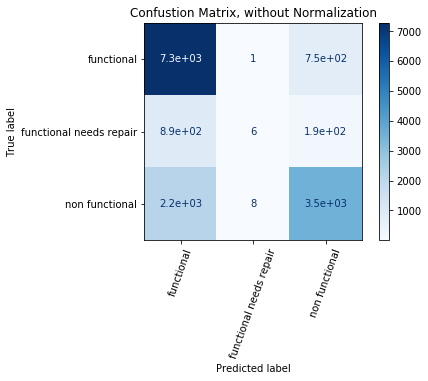

In [31]:
matrix = plot_confusion_matrix(model_log, X_test_ready, y_test_ready,
                            display_labels=le.classes_,
                            cmap=plt.cm.Blues,
                            xticks_rotation=70)
matrix.ax_.set_title('Confustion Matrix, without Normalization')

plt.show()

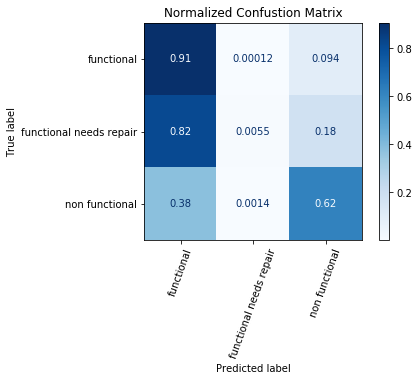

In [32]:
matrix_norm = plot_confusion_matrix(model_log, X_test_ready, y_test_ready,
                                   display_labels=le.classes_,
                                   cmap=plt.cm.Blues,
                                   normalize='true',
                                   xticks_rotation=70)
matrix_norm.ax_.set_title('Normalized Confustion Matrix')

plt.show()

### Compute Multiclass AUC Score

In [33]:
# convert labels from shape n, to n,3
lb = LabelBinarizer()
lb.fit(y_test_ready)
y_test_multi = lb.transform(y_test_ready)
y_hat_test_multi = lb.transform(model_log.predict(X_test_ready))

In [34]:
roc_auc_score(y_test_ready, y_hat_test_multi, multi_class='ovr')

0.6629642214590182

### Multiclass ROC Curves

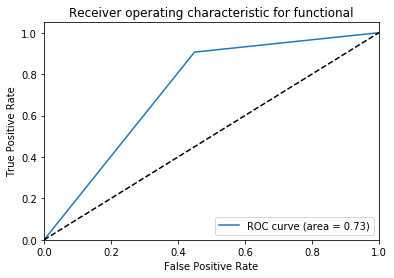

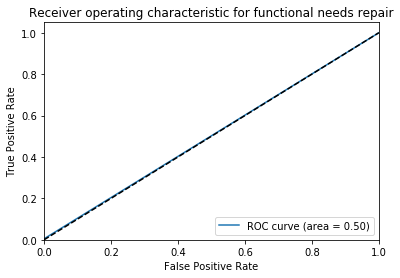

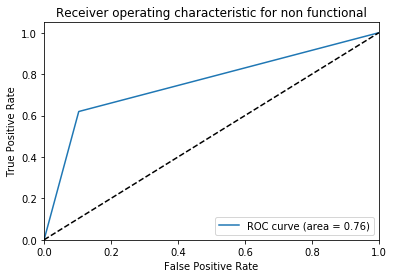

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_multi[:, i], y_hat_test_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i, class_ in enumerate(le.classes_):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {class_}')
    plt.legend(loc="lower right")
    plt.show()

## Save Model

In [36]:
# joblib.dump(model_log, MODEL_PATH+'baseline_log_reg_model.sav')

['models/baseline_log_reg_model.sav']

## Summary of Results

The accuracy of the test set is 0.73 and the training and test data have similar results so it has a good balance of fit, but the precision and recall for the minority class is terrible at 0.36 and 0.02 respectively. Looking at the ROC curve for 'functional needs repair' is 0.51 which is worthless as a predictor.  The poor results for the minority class are to be expected because the classes are so imbalanced.  It is important to be able to predict the minority class of 'functional needs repair' because those waterpumps should be prioritized for maintenance.